## Library Imports ##

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from typing import List
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Data Preprocessing ##

Training data shape: (27455, 784)
Test data shape: (7172, 784)
Training labels shape: (27455, 24)
Test labels shape: (7172, 24)


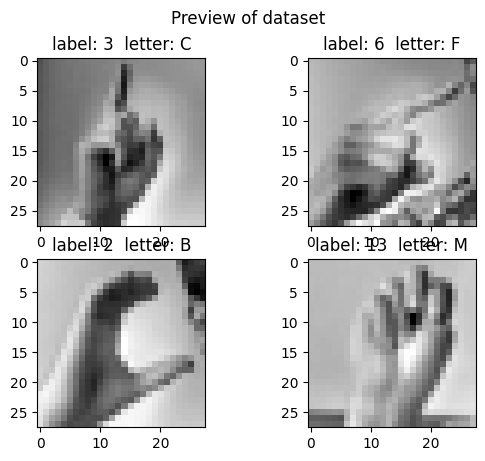

In [14]:
def preprocessing(visualize=False):
    lb=LabelBinarizer()

    # Load the training and test data
    train_df = pd.read_csv('archive/sign_mnist_train.csv')
    test_df = pd.read_csv('archive/sign_mnist_test.csv')

    # Separate features and labels
    x_train = train_df.drop('label', axis=1).values
    y_train = train_df['label'].values
    x_test = test_df.drop('label', axis=1).values
    y_test = test_df['label'].values

    # Mean subtraction
    x_train = x_train - np.mean(x_train, axis=0)
    x_test = x_test - np.mean(x_test, axis=0)

    # Normalization 
    x_train = x_train / np.std(x_train)
    x_test = x_test / np.std(x_test)

    x_train1 =  x_train.reshape(-1,28,28,1)
    x_test1 = x_test.reshape(-1,28,28,1)

    x_train =  x_train.reshape(-1, 28*28).astype(np.float32)
    x_test = x_test.reshape(-1, 28*28).astype(np.float32)

    # Encoding the labels
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)

    if (visualize==True):
    # Preview the dataset
        fig,axe=plt.subplots(2,2)
        fig.suptitle('Preview of dataset')
        axe[0,0].imshow(x_train1[0].reshape(28,28),cmap='gray')
        axe[0,0].set_title('label: 3  letter: C')
        axe[0,1].imshow(x_train1[1].reshape(28,28),cmap='gray')
        axe[0,1].set_title('label: 6  letter: F')
        axe[1,0].imshow(x_train1[2].reshape(28,28),cmap='gray')
        axe[1,0].set_title('label: 2  letter: B')
        axe[1,1].imshow(x_train1[4].reshape(28,28),cmap='gray')
        axe[1,1].set_title('label: 13  letter: M')

        # Confirm preprocessing
        print("Training data shape:", x_train.shape)
        print("Test data shape:", x_test.shape)
        print("Training labels shape:", y_train.shape)
        print("Test labels shape:", y_test.shape)
    
    return x_train, y_train, x_test, y_test
    
x_train, y_train, x_test, y_test = preprocessing(visualize=True)

In [15]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
       
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)  # He initialization
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return x @ self.w.T + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient.T @ self.cur_input
        db = gradient.sum(axis=0)
        self.gradient = [dw, db]
        return gradient @ self.w

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Stabilization 
        shiftx = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shiftx)
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        self.cur_probs = probs
        return self.cur_probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target
class MLP:
    
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, x, y, optimizer, iterations=10, batch_size=24, lambda_reg=0.0, verbose=True):
        history = {
            "loss": [],
            "accuracy": []
        }
        
        for epoch in range(iterations):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(len(x))
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for start_idx in range(0, len(x), batch_size):
                # Create the mini-batch
                end_idx = min(start_idx + batch_size, len(x))
                x_batch = x[start_idx:end_idx]
                y_batch = y[start_idx:end_idx]

                # Forward pass
                output = self.forward(x_batch)

                # Loss computation 
                data_loss = compute_loss(output, y_batch)
                # Regularization loss
                reg_loss = lambda_reg * sum(np.sum(layer.w ** 2) for layer in self.layers if hasattr(layer, 'w'))
                loss = data_loss + reg_loss

                # Backward pass and optimization
                self.backward(y_batch)
                optimizer.step()

                # Compute and store the loss and accuracy
                history["loss"].append(loss)
                predictions = self.predict(x_batch)
                accuracy = self.evaluate_acc(y_batch, predictions)
                history["accuracy"].append(accuracy)
                
            # Verbose output for tracking progress
            if verbose:
                print(f'Epoch {epoch + 1}/{iterations} - Loss: {np.mean(history["loss"][-len(x)//batch_size:])}, '
                      f'Accuracy: {np.mean(history["accuracy"][-len(x)//batch_size:])}')
            

        return history
    
    def predict(self, x):
        predicts = self.forward(x)
        return np.argmax(predicts, axis=1)

    def evaluate_acc(self, y_true, y_pred):
        y_true_indices = np.argmax(y_true, axis=1)
        return np.mean(y_true_indices == y_pred)

class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError
    
# For experiment 3
class RegGradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, lambda_reg: float):
        super().__init__(net)
        self.lr = lr
        self.lambda_reg = lambda_reg

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * (g + self.lambda_reg * p)

# For experiment 5            
class AdamOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(net)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = []
        self.v = []
        self.t = 0

        # Initialize moment vectors for each parameter in the network
        for layer in net.layers:
            layer_m = []
            layer_v = []
            if hasattr(layer, 'parameters') and layer.parameters:
                for param in layer.parameters:
                    layer_m.append(np.zeros_like(param))
                    layer_v.append(np.zeros_like(param))
            self.m.append(layer_m)
            self.v.append(layer_v)
    
    def update(self, layer_index, gradients):
        self.t += 1
        layer_m = self.m[layer_index]
        layer_v = self.v[layer_index]
        
        # Update the parameters of the layer
        for i, (m, v, grad) in enumerate(zip(layer_m, layer_v, gradients)):
            if grad is not None:
                m[:] = self.beta1 * m + (1 - self.beta1) * grad
                v[:] = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

                # Bias correction
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)

                # Update the parameter
                update_value = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.net.layers[layer_index].parameters[i] -= update_value

    # Update the parameters of the network
    def step(self):
        for i, layer in enumerate(self.net.layers):
            if hasattr(layer, 'parameters') and layer.parameters and layer.gradient:
                self.update(i, layer.gradient)
              
# For experiment 1-3
class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g

def compute_loss(output, y_batch):
    # Assuming y_batch is a one-hot encoded matrix of labels
    m = y_batch.shape[0]  # Number of examples
    # Clipping output to avoid division by zero
    output_clipped = np.clip(output, 1e-7, 1 - 1e-7)
    # Compute cross-entropy loss
    loss = -np.sum(y_batch * np.log(output_clipped)) / m
    return loss
    

    

## Building and Training ##

In [16]:
def build_and_train_mlp(x_train, y_train, x_test, y_test, layers, units, iterations):
    """
    This function builds an MLP model with the given architecture, trains it, and evaluates its performance.
    """
    input_size = x_train.shape[-1]  # Determine the input size from the training data
    output_size = y_train.shape[-1]  # Determine the output size from the training data
    
    mlp_layers = []

    # Add the layers to the MLP model based on the specified number of layers and units
    if layers == 0:
        mlp_layers.append(LinearLayer(input_size, output_size))
    elif layers == 1:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    elif layers == 2:
        mlp_layers.append(LinearLayer(input_size, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, units))
        mlp_layers.append(ReLULayer())
        mlp_layers.append(LinearLayer(units, output_size))
    mlp_layers.append(SoftmaxOutputLayer())
    
    # Instantiate the MLP model with the specified layers
    mlp = MLP(*mlp_layers)
    
    # Train the MLP model
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    history = mlp.fit(x_train, y_train, optimizer, iterations=iterations)
    
    # Make predictions with the trained MLP model
    y_pred = mlp.predict(x_test)
    
    # Compute the accuracy
    accuracy = mlp.evaluate_acc(y_test, y_pred)  # Adjust based on y_test format

    return accuracy, history

## Experiments ##

### Experiment 1 ###

In [17]:
def experiment_1(hidden_units, hidden_layers, iterations, plot_show=False):
   
    # Results dictionary to store the accuracy for each architecture and unit configuration
    results = {}
    max_accuracy = 0
    max_accuracy_units = []
    max_accuracy_layers = []
    # Run experiments
    for layers in hidden_layers:
        arch_results = []
        for units in hidden_units:
            # If the architecture has hidden layers (is not empty)
            
            if layers == 0:
                num_layers = "No Hidden Layer"
            elif layers == 1:
                num_layers = "One Hidden Layer"
            elif layers == 2:
                num_layers = "Two Hidden Layers"

            # Print the architecture being tested for clarity
            print(f"Testing architecture: {num_layers}")
            
            # Train the model and evaluate accuracy
            accuracy, history = build_and_train_mlp(
                x_train, y_train, 
                x_test, y_test,
                layers, units,
                iterations
            )
            
            # Store and print the accuracy for the current configuration
            arch_results.append((units, accuracy))
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                max_accuracy_units = units
                max_accuracy_layers = num_layers

            if plot_show:
                # Plot the training loss
                plt.plot(history['loss'])
                plt.title('Training Loss for ' + num_layers + ' Layers and ' + str(units) + ' Units')
                plt.xlabel('Iterations')
                plt.ylabel('Loss')
                plt.show()
            
            print(f"Units: {units}, Test Accuracy: {accuracy}\n")
            
        # Store the results for the current architecture
        results[str(layers)] = arch_results
    print(f"Max Accuracy: {max_accuracy}, for Units: {max_accuracy_units} and Layers: {max_accuracy_layers}")

# Experiment parameters
hidden_units = [32, 64, 128, 256]
hidden_layers = [0,1,2]
    
experiment_1(hidden_units, hidden_layers, iterations=10, plot_show=False)

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8726975812335487, Accuracy: 0.8698977652782001
Epoch 2/10 - Loss: 0.3236030853324885, Accuracy: 0.9759615384615384
Epoch 3/10 - Loss: 0.1995864307523761, Accuracy: 0.9936990093240093
Epoch 4/10 - Loss: 0.14150419546037454, Accuracy: 0.9985067016317015
Epoch 5/10 - Loss: 0.10870259197097155, Accuracy: 0.9994900932400931
Epoch 6/10 - Loss: 0.08868404403699286, Accuracy: 0.999635780885781
Epoch 7/10 - Loss: 0.07473199966668728, Accuracy: 0.9997086247086248
Epoch 8/10 - Loss: 0.0646302805738914, Accuracy: 0.9998178904428905
Epoch 9/10 - Loss: 0.057037971000125656, Accuracy: 0.9998543123543124
Epoch 10/10 - Loss: 0.05103705915134059, Accuracy: 0.9998907342657343
Units: 32, Test Accuracy: 0.6784718349135527

Testing architecture: No Hidden Layer
Epoch 1/10 - Loss: 0.8700393288037873, Accuracy: 0.8715763403263403
Epoch 2/10 - Loss: 0.31852322495335134, Accuracy: 0.9780011655011654
Epoch 3/10 - Loss: 0.19784244679885757, Accuracy: 0.99

### Experiment 2 ###

In [18]:
class SigmoidLayer(NeuralNetLayer):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, dout):
        return dout * (self.output * (1 - self.output))

class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha=0.01):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        self.x = x
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, dout):
        dx = np.ones_like(self.x)
        dx[self.x < 0] = self.alpha
        return dout * dx

def experiment_2(x_train, y_train, x_test, y_test, activation_layer, hidden_units=[64, 64]):
    # Construct the model architecture
    layers = [LinearLayer(x_train.shape[-1], hidden_units[0]), activation_layer()]
    for units in hidden_units[1:]:
        layers.append(LinearLayer(units, units))
        layers.append(activation_layer())
    layers.append(LinearLayer(hidden_units[-1], y_train.shape[-1]))  
    layers.append(SoftmaxOutputLayer())
    

    # Create and train the MLP model
    mlp = MLP(*layers)
    optimizer = GradientDescentOptimizer(mlp, lr=0.001)
    mlp.fit(x_train, y_train, optimizer, iterations=10)
    
    # Evaluate the model
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    return accuracy

# Activation functions to test
activations = {
    "Sigmoid": SigmoidLayer,
    "Leaky ReLU": LeakyReLULayer,
    "ReLU": ReLULayer  
}

# Training and evaluating models with different activations
results = {}
for name, activation_layer in activations.items():
    accuracy = experiment_2(
        x_train, y_train, 
        x_test, y_test, 
        activation_layer, hidden_units=[64, 64] # 2 hidden layers with 64 units each
    )
    results[name] = accuracy
    print(f"{name} activation: Test Accuracy = {accuracy}")

Epoch 1/10 - Loss: 2.8649404768563898, Accuracy: 0.24527782000608087
Epoch 2/10 - Loss: 2.1534973505570423, Accuracy: 0.4707722078645992
Epoch 3/10 - Loss: 1.657612548231506, Accuracy: 0.6140940128711868
Epoch 4/10 - Loss: 1.3131623263676275, Accuracy: 0.6987036966656532
Epoch 5/10 - Loss: 1.0550428564755234, Accuracy: 0.7635410332421202
Epoch 6/10 - Loss: 0.8576720881312373, Accuracy: 0.8189039221647917
Epoch 7/10 - Loss: 0.7018203285351537, Accuracy: 0.8679658204114725
Epoch 8/10 - Loss: 0.5754732887803187, Accuracy: 0.9072333916083916
Epoch 9/10 - Loss: 0.4716246769907052, Accuracy: 0.9370993589743588
Epoch 10/10 - Loss: 0.38601935776239704, Accuracy: 0.9564726487280835
Sigmoid activation: Test Accuracy = 0.701617401003904
Epoch 1/10 - Loss: 0.6506640441413611, Accuracy: 0.9192526223776224
Epoch 2/10 - Loss: 0.049694578772420187, Accuracy: 1.0
Epoch 3/10 - Loss: 0.01717115374707515, Accuracy: 1.0
Epoch 4/10 - Loss: 0.009834797804239091, Accuracy: 1.0
Epoch 5/10 - Loss: 0.00669191267

### Experiment 3 ###

In [19]:
lambdas = [0, 0.001, 0.01, 0.1, 1]  # Different values of lambda for L2 regularization
batch_size = 24 # Mini-batch size
units = 32 # Number of units in the hidden layers
for lambda_reg in lambdas:
    print(f"Training with lambda = {lambda_reg} and units = {units}")
    mlp = MLP(
        LinearLayer(x_train.shape[-1], units),
        ReLULayer(),
        LinearLayer(units, units),
        ReLULayer(),
        LinearLayer(units, y_train.shape[-1]),
        SoftmaxOutputLayer()
    )
    optimizer = RegGradientDescentOptimizer(mlp, lr=0.001, lambda_reg=lambda_reg)
    history = mlp.fit(x_train, y_train, optimizer, iterations=10, batch_size=batch_size, lambda_reg=lambda_reg)
    y_pred = mlp.predict(x_test)
    accuracy = mlp.evaluate_acc(y_test, y_pred)
    print(f"Accuracy with L2 regularization and lambda={lambda_reg}: {accuracy}")

Training with lambda = 0 and units = 32
Epoch 1/10 - Loss: 0.7661845087271042, Accuracy: 0.900458916083916
Epoch 2/10 - Loss: 0.07993919993125036, Accuracy: 0.9993079836829836
Epoch 3/10 - Loss: 0.024921689528813164, Accuracy: 1.0
Epoch 4/10 - Loss: 0.013353949368909318, Accuracy: 1.0
Epoch 5/10 - Loss: 0.008894345207815268, Accuracy: 1.0
Epoch 6/10 - Loss: 0.00646852061233511, Accuracy: 1.0
Epoch 7/10 - Loss: 0.005082045652681833, Accuracy: 1.0
Epoch 8/10 - Loss: 0.004117897271900618, Accuracy: 1.0
Epoch 9/10 - Loss: 0.003477859808377118, Accuracy: 1.0
Epoch 10/10 - Loss: 0.0029746354480766103, Accuracy: 1.0
Accuracy with L2 regularization and lambda=0: 0.7374511991076408
Training with lambda = 0.001 and units = 32
Epoch 1/10 - Loss: 1.0574366807064042, Accuracy: 0.8726325757575756
Epoch 2/10 - Loss: 0.34413961823807215, Accuracy: 0.9985067016317017
Epoch 3/10 - Loss: 0.29786934623260475, Accuracy: 1.0
Epoch 4/10 - Loss: 0.2960726695815148, Accuracy: 1.0
Epoch 5/10 - Loss: 0.298620433

### Experiment 4 ###

In [20]:
# Load the data
train_df = pd.read_csv('archive/sign_mnist_train.csv')
test_df = pd.read_csv('archive/sign_mnist_test.csv')

# Extract labels and features
y_train = train_df.pop('label').values
x_train = train_df.values
y_test = test_df.pop('label').values
x_test = test_df.values

# Normalize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

# Reshape the features
x_train = x_train.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

# One-hot encode labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the ConvNet model
class ConvNet(nn.Module):
    def __init__(self, hidden_units):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, hidden_units)  # 3x3 is the spatial dimension of the output volume
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, 26)  # 26 classes
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Training and evaluation function
def train_and_evaluate_model(hidden_units):
    model = ConvNet(hidden_units)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(10):  # 10 iterations
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()

    test_acc = correct / total
    return test_acc

# Running the experiments
hidden_units_options = [32, 64, 128, 256]
results = {}
for hidden_units in hidden_units_options:
    test_acc = train_and_evaluate_model(hidden_units)
    results[hidden_units] = test_acc
    print(f"Training with {hidden_units} hidden units, Test Accuracy: {test_acc:.4f}")

#Find the best performance
best_units = max(results, key=results.get)
print(f"Best performance with {best_units} hidden units: {results[best_units]:.4f}")

KeyboardInterrupt: 

### Experiment 5 ### 

In [21]:
# MAKE SURE TO RUN THE FIRST PREPROCESSING CELL RIGHT BEFORE RUNNING THIS CELL 
# TO MAKE SURE THE DATA IS IN THE CORRECT FORMAT
# THE ORDER IS EXPERIMENT 4, PREPROCESSING, EXPERIMENT 5
preprocessing()

# Define the MLP architecture 
units = 256 # If you want to skip running the previous cell you can use 128 or 256
input_size = x_train.shape[-1]  # Determine the input size from the training data
output_size = y_train.shape[-1]  # Determine the output size from the training data
mlp = MLP(
    LinearLayer(input_size, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, units),  
    ReLULayer(),            
    LinearLayer(units, output_size),   
    SoftmaxOutputLayer()    
)

# Initialize the Optimizer 
adam_optimizer = AdamOptimizer(mlp, lr=0.001)

# Train the MLP model
mlp.fit(x_train, y_train, optimizer=adam_optimizer, iterations=10, verbose=True)

# Evaluate the model's performance on the test set
y_pred = mlp.predict(x_test)
accuracy = mlp.evaluate_acc(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")


ValueError: operands could not be broadcast together with shapes (24,24) (24,1,28,24) 